In [1]:
import os
import json

import matplotlib.pyplot as plt
import numpy as np
import torch
from tqdm import tqdm

import transformer_lens

import spacy

In [2]:
# Load the spaCy model
spacy_model = spacy.load("en_core_web_sm")

In [3]:
device_name = "cpu"
if torch.cuda.is_available():
    device_name = "cuda" # CUDA for NVIDIA GPU

device = torch.device(device_name)
print(f"Device: {device_name}")

Device: cuda


In [4]:
model_name = "gpt2-small"
model = transformer_lens.HookedTransformer.from_pretrained(model_name)

Loaded pretrained model gpt2-small into HookedTransformer


In [5]:
text = "This is a test of tokenizers, running jumping Newer, wowrarelongword, Neel Nanda, \"epic\"!"

gpt_tokens = model.to_tokens(text).squeeze(0)
gpt_tokens_str = [model.to_single_str_token(int(t)) for t in gpt_tokens]

print(gpt_tokens)
print(gpt_tokens_str)

tensor([50256,  1212,   318,   257,  1332,   286, 11241, 11341,    11,  2491,
        14284,   968,   263,    11, 28796,   430,  2411,   506,  4775,    11,
         3169,   417,   399,  5282,    11,   366,   538,   291, 40484],
       device='cuda:0')
['<|endoftext|>', 'This', ' is', ' a', ' test', ' of', ' token', 'izers', ',', ' running', ' jumping', ' New', 'er', ',', ' wow', 'ra', 'rel', 'ong', 'word', ',', ' Ne', 'el', ' N', 'anda', ',', ' "', 'ep', 'ic', '"!']


In [6]:
doc = spacy_model(text)
word_idxs = [t.text for t in doc if t.is_alpha]
print(word_idxs)

['This', 'is', 'a', 'test', 'of', 'tokenizers', 'running', 'jumping', 'Newer', 'wowrarelongword', 'Neel', 'Nanda', 'epic']


In [7]:
i = 0
cur = 0 # current word index
sub_idx = 0 # sub index of current word

result = []
while i < len(gpt_tokens_str):
    t = gpt_tokens_str[i].strip()

    cur_word = word_idxs[cur]
    # if token is part of current word, update sub_idx, continue to next token
    if cur_word.find(t, sub_idx) != -1:
        result.append((t, cur))
        sub_idx += len(t)
        i += 1
    else:
        # if token not in cur_word, check next word
        if cur+1 < len(word_idxs) and t in word_idxs[cur+1]:
            cur += 1
            sub_idx = 0
        # if not in cur_word or next word, give up and continue
        else:
            i += 1
            result.append((t, -1))

result

[('<|endoftext|>', -1),
 ('This', 0),
 ('is', 1),
 ('a', 2),
 ('test', 3),
 ('of', 4),
 ('token', 5),
 ('izers', 5),
 (',', -1),
 ('running', 6),
 ('jumping', 7),
 ('New', 8),
 ('er', 8),
 (',', -1),
 ('wow', 9),
 ('ra', 9),
 ('rel', 9),
 ('ong', 9),
 ('word', 9),
 (',', -1),
 ('Ne', 10),
 ('el', 10),
 ('N', 11),
 ('anda', 11),
 (',', -1),
 ('"', -1),
 ('ep', 12),
 ('ic', 12),
 ('"!', -1)]

In [8]:
def map_word_index(text):
    gpt_tokens = model.to_tokens(text).squeeze(0)
    gpt_tokens_str = [model.to_single_str_token(int(t)) for t in gpt_tokens]

    doc = spacy_model(text)
    word_idxs = [t.text for t in doc if t.is_alpha]

    if not len(word_idxs):
        return []

    i = 0
    cur = 0 # current word index
    sub_idx = 0 # sub index of current word

    result = []
    while i < len(gpt_tokens_str):
        t = gpt_tokens_str[i].strip()
        # skip if token is just a newline or other whitespace
        if not len(t):
            result.append((t, i, -1))
            i += 1
            continue

        cur_word = word_idxs[cur]
        # if token is part of current word, update sub_idx, continue to next token
        if cur_word.find(t, sub_idx) != -1:
            result.append((t, i, cur))
            sub_idx += len(t)
            i += 1
        else:
            # if token not in cur_word, check next word
            if cur+1 < len(word_idxs) and t in word_idxs[cur+1]:
                cur += 1
                sub_idx = 0
            # if not in cur_word or next word, give up and continue
            else:
                result.append((t, i, -1))
                i += 1 

    return result

In [9]:
map_word_index(text)

[('<|endoftext|>', 0, -1),
 ('This', 1, 0),
 ('is', 2, 1),
 ('a', 3, 2),
 ('test', 4, 3),
 ('of', 5, 4),
 ('token', 6, 5),
 ('izers', 7, 5),
 (',', 8, -1),
 ('running', 9, 6),
 ('jumping', 10, 7),
 ('New', 11, 8),
 ('er', 12, 8),
 (',', 13, -1),
 ('wow', 14, 9),
 ('ra', 15, 9),
 ('rel', 16, 9),
 ('ong', 17, 9),
 ('word', 18, 9),
 (',', 19, -1),
 ('Ne', 20, 10),
 ('el', 21, 10),
 ('N', 22, 11),
 ('anda', 23, 11),
 (',', 24, -1),
 ('"', 25, -1),
 ('ep', 26, 12),
 ('ic', 27, 12),
 ('"!', 28, -1)]

In [14]:
token_idx = []
word_idx = []

N_LINES = 5000

with open('datasets/brown.dev', 'r') as f:
    prewar = [line.rstrip("\n") for line in f.readlines()]

    for i, line in tqdm(enumerate(prewar[:N_LINES]), total=N_LINES):
        # print(i)
        for _, tid, wid in map_word_index(line)[:100]:
            if wid < 0:
                continue
            token_idx.append(tid)
            word_idx.append(wid)

100%|██████████| 5000/5000 [00:29<00:00, 167.68it/s]


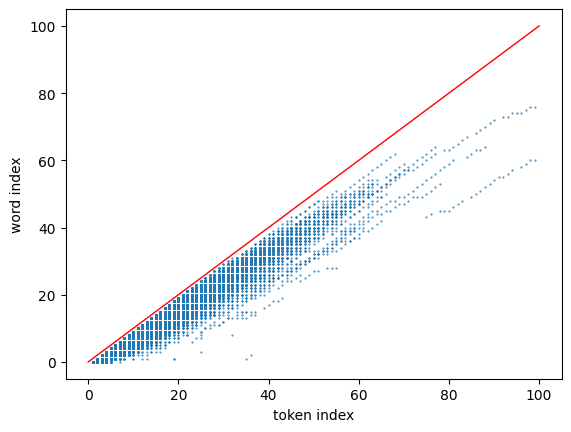

In [15]:
plt.scatter(token_idx, word_idx, s=0.2) 

# x = y line
plt.plot([0, 100], [0, 100], 'r-', linewidth=1)

plt.xlabel('token index')
plt.ylabel('word index')
plt.show()

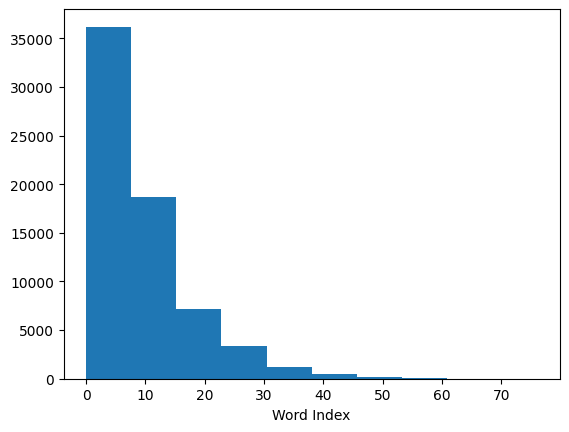

In [17]:
plt.hist(word_idx)
plt.xlabel("Word Index")
plt.show()